# Ch3: Geometry & Algebra of Tensors
    
## 3.1 Motivation and Intuition

A Video Analysis with Tensor Decomposition in Python example can be found at:
https://towardsdatascience.com/video-analysis-with-tensor-decomposition-in-python-3a1fe088831c

Other Examples are presented below, using a tensorisation step that is hand tailored to each examples, with attempts to generalise

Indexing routines can be found in https://numpy.org/doc/stable/reference/arrays.indexing.html



In [ ]:
import math

def tensorisation_Values (Df, components, value="value", aggFunc=np.mean):
    if components >= Df.shape[1]:
        print ("Number of components must be less or equal to number of the columns in the input matrix. Exiting without creating the tensor")
        return
    minVals = []
    maxVals = []
    tensorShape = []
    for i in range(components):
        minVal = Df.iloc[:,i].min()
        # this will be an index, therefore starting from zero is necessary
        if minVal > 0:
            Df.iloc[:,i] += minVal
            minVal = 0
        if minVal < 0:
            Df.iloc[:,i] -= minVal
            minVal = 0
        minVals.append(minVal)
        # also the max value need to be positive non-zero, because it will be the tensor shape 
        maxVal = Df.iloc[:,i].max()
        if maxVal <= 0:
            Df.iloc[:,i] -= maxVal + 1
            maxVal = 1
        maxVals.append(maxVal)
        print("mode  " + str(i) + " max value =" + str(maxVal) + ", min value = " + str(minVal))
        tensorShape.append(int(maxVal)+1)

    # update the values in the array, to be used as indices
    for k,j in Df.iterrows():
            for i in range(components):
                j[i] = int(math.floor(j[i])) + abs(int(minVals[i])) + 1
    print (tensorShape)
    tensorShape = tuple(tensorShape) 
    tensor_array = np.zeros(tensorShape)
    count = 0
    for k,j in Df.iterrows():
        count = count + 1
        t_index = tuple(
            int(j[i]) for i in range(components)
        )
        #print (t_index)
        tensor_array[t_index] = aggFunc(j[value])

    return tensor_array

In [ ]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np

userdata = pd.read_csv('data/GlobalLandTemperaturesByMajorCity.csv')
columns = ['dt','AverageTemperature','AverageTemperatureUncertainty','City','Country','Latitude','Longitude'] # such that these will be x
df=userdata[columns].copy()
Values = userdata["AverageTemperature"] # this will be the values of the tensor
df

In [ ]:
# We will tensorise in the same order mentioned in chapter 3 first section on motivational problem
# First example is one temperature value as a scalar (rank-zero tensor), which does not require tensorisation, just indexing will do
df.iloc[0, 1] # specifying the index values, which is not usually interpreted easily


In [ ]:
df.loc[(df['City']== 'Abidjan') & (df['dt']=='1849-01-01') ,['AverageTemperature']] # specifing the values needed (city and date values)

In [ ]:
# Second example is all temperature values in this dataset or in a specific city as a vector (rank-one tensor), which does not require tensorisation, just indexing will do

df.loc[df['City'] == 'Abidjan']['AverageTemperature']

In [ ]:
# Third example is temperature values per city (rank-two tensor). We will do it using pivot tables, and again with tensorisation
# pivot tables are another method in handling multi-way analysis
# checking how many cardiac cases in each age value

cityTempMeans = df.pivot_table(values='AverageTemperature',
                               index='City', 
                               aggfunc=np.mean,               ## aggfunc='size', # size if you want to aggregate by frequency counting
                               fill_value=0)
cityTempMeans

In [ ]:
cityTempMeans.iloc[0,0] # Average temperature for Abidjan by indexing the pivot table

In [ ]:
df.loc[df['City'] == 'Abidjan']['AverageTemperature'].mean() # getting to the same value from the original dataset DataFrame, probably the mean function used here is not np.mean since the value is slightly different, but could be rounding error

In [ ]:
for i in range(1):
    print(sdf.iloc[:,i].min())

In [ ]:
# tensorising by arranging the columns as coordinates first, and last column is the value to aggregate on

columns = ['City','AverageTemperature'] # such that these will be x
sdf=userdata[columns].copy()

# we need to encode all coordinate columns numerically
from sklearn import preprocessing

# lbl_encoder object knows how to understand word labels.
city_encoder = preprocessing.LabelEncoder()

sdf['CityBasis']= city_encoder.fit_transform(sdf['City'])
sdf['CityBasis'].unique()

In [ ]:
city_encoder.classes_

In [ ]:
city_encoder.inverse_transform([0])

In [ ]:
city_encoder.transform(['Abidjan'])

In [ ]:
columns = ['CityBasis', 'City','AverageTemperature'] # such that these will be x
sdf=sdf[columns].copy()
sdf

In [ ]:
import tensorly as tl

tensor_array = tensorisation_Values (sdf, 1, value="AverageTemperature", aggFunc=np.mean)
tensor2 = tl.tensor(tensor_array)
tensor2.shape


In [ ]:
tensor2 # the tensorisation function can also be updated to handle nan values, and to be vectorised and optimisaed for parallel processing

In [ ]:
# Fourth example is temperature values per location as Latitude & Longitude  (rank-three tensor). 
#Attemping pivot tables, will still be rank-two, as we create a matrix with the both location columns flattened in one mode
columns = ['dt','AverageTemperature','AverageTemperatureUncertainty','City','Country','Latitude','Longitude'] # such that these will be x


locTempMeans = df.pivot_table(values='AverageTemperature',
                               index=['Latitude','Longitude'], 
                               aggfunc=np.mean,               ## aggfunc='size', # size if you want to aggregate by frequency counting
                               fill_value=0)
locTempMeans



In [ ]:
#We will do it using tensorisation

columns = ['Latitude','Longitude','AverageTemperature'] 
sdf=userdata[columns].copy()

sdf # 'Latitude','Longitude' contain numeric values followed by N/S in the first, and E/W in the second, which is degree minute second (DMS) coordinates 
# We will need to be numerically encode them to be turned to coordinate basis using decimal degrees
# there is a solution here https://medium.com/@quinn.dougherty92/simple-geographical-encoding-8293fde9e964

In [ ]:
!pip install dms2dec

In [ ]:
# geopandas has interesting solutions, but will use dms2dec for simplicity
from dms2dec.dms_convert import dms2dec
sdf['Latitude'] = sdf['Latitude'].apply(dms2dec)
sdf['Longitude'] = sdf['Longitude'].apply(dms2dec)
sdf['Latitude'] = sdf['Latitude'].astype(float)
sdf['Longitude'] = sdf['Longitude'].astype(float)
sdf

In [ ]:
# we will need to update the tensorisation function to be able to aggregate by mean or other function, and take
# the values as mean of rows returned from a condition per column in the dataframe
# this is almost tailored to Latitude & Longitude specific values, it is better to be updated to ranges, such that
# values are aggregated when they are >= the current basis index and < next basis index
# many optimisations can be achived for vectorisation, paralleisation, quantisation
def tensorisation2_Values (Df, components, value="value", aggFunc=np.mean):
    if components >= Df.shape[1]:
        print ("Number of components must be less or equal to number of the columns in the input matrix. Exiting without creating the tensor")
        return
    minVals = []
    maxVals = []
    tensorShape = []
    for i in range(components):
        minVal = Df.iloc[:,i].min()
        # this will be an index, therefore starting from zero is necessary
        if minVal > 0:
            Df.iloc[:,i] += minVal
            minVal = 0
        if minVal < 0:
            Df.iloc[:,i] -= minVal
            minVal = 0
        minVals.append(minVal)
        # also the max value need to be positive non-zero, because it will be the tensor shape 
        maxVal = Df.iloc[:,i].max()
        if maxVal <= 0:
            Df.iloc[:,i] -= maxVal + 1
            maxVal = 1
        maxVals.append(maxVal)
        print("mode  " + str(i) + " max value =" + str(maxVal) + ", min value = " + str(minVal))
        tensorShape.append(int(maxVal)+1)

    # update the values in the array, to be used as indices
    for k,j in Df.iterrows():
            for i in range(components):
                j[i] = int(math.floor(j[i])) + abs(int(minVals[i])) + 1
    print (tensorShape)
    tensorShape = tuple(tensorShape) 
    tensor_array = np.zeros(tensorShape)
    
    ## two useful functions
    np.unravel_index(0, tensorShape) # flat linear index to multidimensional index 
    np.ravel_multi_index([tensorShape[i]-1 for i in range(len(tensorShape))], tensorShape) # multidimensional index to flat linear index

    for i in range (np.prod(tensorShape)-1): # iterate through the tensor flat indices, can try for element in np.nditer(arr): then get the index of the element
        t_index = np.unravel_index(i, tensorShape) # get the tensor multidimensional index
        print ("i: " + str(i) + " t_in: " + str(t_index))
        condition = '' # accumulate the conditions to add to the data frame selection
        for j in range(len(t_index)):       # iterate through the dataframe columns
            if j==0:
                condition += '(Df[Df.columns[' + str(j)+']] == ' + str(t_index[j]) + ')'
            else:
                condition += ' & (Df[Df.columns[' + str(j)+']]  == ' + str(t_index[j]) + ')'
            print ("j: " + str(j) + " column: " + Df.columns[j] + " cond: " + condition)
            
        #print ("Condition is: " + condition)
        if len(condition) > 0:    
            #print (eval(condition))
            tensor_array[t_index] = aggFunc(Df.loc[eval(condition)]['AverageTemperature'])
        else:
            tensor_array[t_index] = aggFunc(Df.loc['AverageTemperature'])


    return tensor_array

In [ ]:
tensor_array =  tensorisation2_Values (sdf, 2, value="AverageTemperature", aggFunc=np.mean)
tensor2 = tl.tensor(tensor_array)
tensor2.shape

In [ ]:
tensor2


In [ ]:
# Fifth example is temperature values per location as Latitude & Longitude & date  (rank-four tensor). We will do it using tensorisation
#Attemping pivot tables, will still be rank-two, as we create a matrix with the both location columns and time column flattened in one mode
columns = ['dt','AverageTemperature','AverageTemperatureUncertainty','City','Country','Latitude','Longitude'] # such that these will be x


locTempMeans = df.pivot_table(values='AverageTemperature',
                               index=['Latitude','Longitude','dt'], 
                               aggfunc=np.mean,               ## aggfunc='size', # size if you want to aggregate by frequency counting
                               fill_value=0)
locTempMeans


In [ ]:
#We will do it using tensorisation

columns = ['Latitude','Longitude','dt', 'AverageTemperature'] 
sdf=userdata[columns].copy()

sdf


In [ ]:
# we have here a date column, we can create time series by lagging function and quantisation of values, but will simply encode here
date = pd.to_datetime(sdf['dt'])
date

In [ ]:
sdf['Latitude'] = sdf['Latitude'].apply(dms2dec)
sdf['Longitude'] = sdf['Longitude'].apply(dms2dec)
sdf['Latitude'] = sdf['Latitude'].astype(float)
sdf['Longitude'] = sdf['Longitude'].astype(float)

date_encoder = preprocessing.LabelEncoder()

sdf['dtBasis']= date_encoder.fit_transform(pd.to_datetime(sdf['dt']))
sdf['dtBasis'] = sdf['dtBasis'].astype(float)
sdf['dtBasis'].unique()

In [ ]:
columns = ['Latitude','Longitude','dtBasis', 'AverageTemperature'] 
sdf=sdf[columns].copy()

sdf

In [ ]:
tensor_array =  tensorisation2_Values (sdf, 3, value="AverageTemperature", aggFunc=np.mean)
tensor2 = tl.tensor(tensor_array)
tensor2.shape

In [ ]:
tensor2

## We will consider another problem using Data already in tensor form.


The data set is from http://www.models.life.ku.dk/nwaydata
in Matlab form, and can be read by scipy loadmat function, and saved as numpy arrays for easier loads later

The data has X variable as 3-way tensor of  5 samples in mode - 1 (rows) 5 × 51 × 201. , containing different amounts of tyrosine, tryptophan and phenylalanine amino acids belong to three amino acids dissolved in phosphate buffered water. The samples were measured by fluorescence (excitation 250-300 nm, emission 250-450 nm, 1 nm intervals) on a spectrofluorometer 

The data has Y variable, which is the ground truth,  the known concentrations of the three chemicals (mode-2) that are in the samples (mode-1) 

In [ ]:
import scipy.io
amino = scipy.io.loadmat('data/amino.mat')

In [ ]:
X = amino.get('X')

In [ ]:
Y = amino.get('Y')

In [ ]:
import numpy as np

np.save('data/amino_x', X)
np.save('data/amino_y', Y)

In [ ]:
X.shape

In [ ]:
Y.shape

In [ ]:
# doing Parafac decomposition
from tensorly.decomposition import parafac
weights, factors = parafac(X,rank = 3, verbose = 2)

## PARAFAC should have three components and therefore a 5 × 3 so called score matrix (first mode loading matrix). Each column in this score matrix should approximately match the concentration of one of the three aminoacids which are held in the 5 × 3 Y matrix. Matching in this case, means that the corresponding columns should be correlated.

In [ ]:
len(factors)

In [ ]:
[f.shape for f in factors]

In [ ]:
np.isclose(Y, factors[0]) # obviously they are not close enough for numpy, will do all possible column permutations correlation then

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def corrEstimate (i, j, Y, factors):
    data = {
        'Y': Y[:,i], 
        'Y_p': factors[0][:,j]
    }

    df = pd.DataFrame(data, columns=['Y', 'Y_p'])
    corr = df.corr()
    print("Correlation matrix of estimated column" + str(i) + " with ground truth " + str(j) + " is : ")
    print(corr)
    
    return corr, ax

In [ ]:
plt.figure(figsize=(15, 12))
ax = 0
corrList = []
for i in range(Y.shape[1]):
    for j in range(factors[0].shape[1]):
        corr, ax = corrEstimate(i, j, Y, factors)
        corrList.append(corr)

n=0 # there is a bug that makes the plot read the same correlation matrix every time, I tried inside the function, and then added the list to separate the variables, and not good
for i in range(Y.shape[1]):
    for j in range(factors[0].shape[1]):
        ax = plt.subplot(3, 3, n+1)
        plt.imshow(corrList[n],cmap='coolwarm',interpolation='nearest')
        n= n+1

### It is obvious that the first estimated chemical matches the first ground truth, more than the other two

### The second estimated chemical matches the third ground truth, 

### The third estimated checmical matches the second ground truth

### The second and third are swapped

# Ch6: Fundamentals of Tensor Analysis & Applications

## 6.1 Scientific Computing Applications

## Second Problem is a survey answers about happiness scores related to 3 conditions. This created a three-way contingency table has as its variables: Happiness reported by participants in a survey (i mode-1 : 3 categories), Number of siblings (j mode-2 : Siblings - 5 categories) and the Years of schooling completed (k mode-3 : Schooling - 4 categories). It is thus a frequency table containing in the cells the number of people with a particular combination of categories. 

## the data is stored in a dat file that reads a 2 dimensional matricised tensor, (12, 5), assuming that reshaping into (3, 4, 5) and swapping the mode-2 and mode-3 in the problem definition in https://three-mode.leidenuniv.nl/ will be ok

## Will decompose with Tucker to find which rank gives the best fit.

In [ ]:
import csv

# read flash.dat to a list of lists
datContent = [i.strip().split() for i in open("data/Happiness.dat").readlines()]

X = np.array(datContent)
X.shape

In [ ]:
X = X.reshape(3, 4, 5)
X.shape

In [ ]:
# doing Tucker decomposition
from tensorly.decomposition import tucker
import tensorly as tl
import math



def doTucker (X, rank):
    X = tl.tensor(X,dtype=float)
    core, factors = tucker(X, rank=rank)
    tucker_reconstruction_2 = tl.tucker_to_tensor((core, factors))

    tk_RMSE = math.sqrt(np.square(np.subtract(X,tucker_reconstruction_2)).mean() )
    print ("Tucker " + str(rank) + " RMSE = ", tk_RMSE)
    return core ,factors, tk_RMSE

In [ ]:
# doing Tucker decomposition
from tensorly.decomposition import tucker
import tensorly as tl

ranks = []
tucker_RMSE=[]

for i in range(np.prod(X.shape)): # iterate through the flat index
    rank= np.unravel_index(i, X.shape) # get the multidimensional index to use as a rank, in case it does not contain a zero, this will traverse all possible ranks
    if np.all(rank):
        core ,factors, tk_RMSE = doTucker(X, rank)
        tucker_RMSE.append(tk_RMSE)
        ranks.append(str(rank))


max = np.argmin(tucker_RMSE)
print ("Lowest RMSE achieched at rank = " + ranks[max]) # this will show the full matrix rank, 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure( figsize=(20,6))
plt.style.use('ggplot')

x_pos = [i for i, _ in enumerate(ranks)]

plt.bar(ranks, tucker_RMSE, color='green')
plt.xlabel("Dimensionality Reduction Methods")
plt.ylabel("RMSE")
plt.title("Comparing Classification RMSE using RandomForest on Linear unsupervised PCA, supervised LDA/QDA and various Embedding Learning Algorithms")

plt.xticks(x_pos, ranks)

plt.show()

## Looking at all possible ranks reconstruction error, it seems the highest errors occured when all modes were reduced, but when first mode only was reduced, the error was small, which means it is not very dominant in this dataset, and the third mode seems to be the most dominant.  

In the book ( Kroonenberg, P.M., 2008. Applied multi-way data analysis, Wiley series in probability and statistics. Wiley-Interscience, Hoboken, N.J.) the author showed that rank (2,2,2) was the most fit to this dataset, which is proven here as well. The software he used can be downloaded from https://three-mode.leidenuniv.nl/ , 

### Tensorlab (Matlab package) Tensorisation Functions:

##### A 2-dimensional implementation is available in scipy package that is not based on tensor higher dimensions

In [56]:
from scipy.linalg import hankel


v = [1, 2, 3, 4, 5]
V = hankel(v);
V


array([[1, 2, 3, 4, 5],
       [2, 3, 4, 5, 0],
       [3, 4, 5, 0, 0],
       [4, 5, 0, 0, 0],
       [5, 0, 0, 0, 0]])

In [59]:
V = hankel(V);
V


array([[1, 5, 4, 3, 2, 2, 1, 5, 4, 3, 3, 2, 1, 5, 4, 4, 3, 2, 1, 5, 5, 4,
        3, 2, 1],
       [5, 4, 3, 2, 2, 1, 5, 4, 3, 3, 2, 1, 5, 4, 4, 3, 2, 1, 5, 5, 4, 3,
        2, 1, 0],
       [4, 3, 2, 2, 1, 5, 4, 3, 3, 2, 1, 5, 4, 4, 3, 2, 1, 5, 5, 4, 3, 2,
        1, 0, 0],
       [3, 2, 2, 1, 5, 4, 3, 3, 2, 1, 5, 4, 4, 3, 2, 1, 5, 5, 4, 3, 2, 1,
        0, 0, 0],
       [2, 2, 1, 5, 4, 3, 3, 2, 1, 5, 4, 4, 3, 2, 1, 5, 5, 4, 3, 2, 1, 0,
        0, 0, 0],
       [2, 1, 5, 4, 3, 3, 2, 1, 5, 4, 4, 3, 2, 1, 5, 5, 4, 3, 2, 1, 0, 0,
        0, 0, 0],
       [1, 5, 4, 3, 3, 2, 1, 5, 4, 4, 3, 2, 1, 5, 5, 4, 3, 2, 1, 0, 0, 0,
        0, 0, 0],
       [5, 4, 3, 3, 2, 1, 5, 4, 4, 3, 2, 1, 5, 5, 4, 3, 2, 1, 0, 0, 0, 0,
        0, 0, 0],
       [4, 3, 3, 2, 1, 5, 4, 4, 3, 2, 1, 5, 5, 4, 3, 2, 1, 0, 0, 0, 0, 0,
        0, 0, 0],
       [3, 3, 2, 1, 5, 4, 4, 3, 2, 1, 5, 5, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [3, 2, 1, 5, 4, 4, 3, 2, 1, 5, 5, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0,
      

In [60]:
V.shape

(25, 25)

In [61]:
V = hankel(V);
V

array([[1, 5, 4, ..., 0, 0, 0],
       [5, 4, 3, ..., 0, 0, 0],
       [4, 3, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [62]:
V.shape

(625, 625)

In [57]:
from scipy.linalg import toeplitz
V = toeplitz(v);
V


array([[1, 2, 3, 4, 5],
       [2, 1, 2, 3, 4],
       [3, 2, 1, 2, 3],
       [4, 3, 2, 1, 2],
       [5, 4, 3, 2, 1]])

In [58]:
from scipy.linalg import circulant
V = circulant(v);
V

array([[1, 5, 4, 3, 2],
       [2, 1, 5, 4, 3],
       [3, 2, 1, 5, 4],
       [4, 3, 2, 1, 5],
       [5, 4, 3, 2, 1]])

### Attempting to implement hankelisation in higher dimensions as explained in https://www.tensorlab.net/doc/tensorization.html#hankelization-sec  and https://core.ac.uk/download/pdf/34637588.pdf 

and implemented in matlab. Only the required functions to run the BSS example are attempted with minimum functionality

##### Hankelization : Will lead to curse of dimensionality, and reduced forms are performed by tensor factorisation

In [2]:
import numpy as np
import math

def hankelize (v, order = 2, sizes = None , indices = None,Dim = 1 ):
    N = len(v)
    if order > N:
        print ('The order should not be larger than the number of elements in the tensorized dimension!')
        return
    if order < 2:
        print ('The order must be larger than or equal to 2!')
        return
    if order == 2:
        if sizes == None:
            I = int(math.ceil(N / 2))
            J = N - I + 1
        else:
            I = sizes[0]
            J = sizes[1]
        H = np.ndarray(shape=(I,J), dtype=np.int8)
        for i in range (0, I):
            for j in range (0, J):
                H[i, j] = v[i+j-1]
    else:
            # ceil((1:options.Order-1)*N/options.Order);
            I = np.ndarray(shape=(order), dtype=np.int8) # resulting tensorShape
            # Y(ceil((k-1)*N/K):               ceil(k*N/K))  segments
            elements = 0
            for i in range (0, order):
                if sizes == None:
                    if i < order - 1:
                        I[i] = int(math.ceil(N / order))
                        #I[i] = int((N+order) / order) + 1
                        elements += I[i]
                    else:
                        I[i]  = N - order + 1
                        #I[i] = N +order - elements
                else:
                    I[i] = sizes[i]
            tensorshape = tuple(I)
            print (tensorshape)
            H = np.ndarray(shape=tensorshape, dtype=np.int8)
            
            # This method of iterating through the high dimensional space in one-level non-nested and hard coded for every order like the above 2-D example
            # might be the reason the order of the elements are not as described in the references. However the diagonal, anti-diagonal, or skew diagonal 
            # properties seem to be preserved. Further testing might be needed to maintain that a Hankel tensor has constant anti-hyperplanes, and take
            # care of all exception handling, like mismatching order or parameter values or too large tensor to create a smaller one.
            
            for i in range (np.prod(I)): # iterate through the tensor flat indices
                t_index = np.unravel_index(i, I) # get the tensor multidimensional index
                print (t_index)
                H[t_index] =v[np.sum(t_index) - order + 1]
    return H

In [12]:
import numpy as np
import tensorly as tl

    
def hankelize(X, **kwargs):
    defaultKwargs = { 'Order': 2,
        'Dim': 1,
        'Sizes': np.NaN,
        'Ind': np.NaN,
        'PermToFirst': False,
        'Full': 'auto',
        'FullLimit': 1}
    order = kwargs.get('Order', 2)
    dim = kwargs.get('Dim', 1)
    sizes = kwargs.get('Sizes', np.NaN)
    ind = kwargs.get('Ind', np.NaN)
    perm_to_first = kwargs.get('PermToFirst', False)
    full = kwargs.get('Full', 'auto')
    full_limit = kwargs.get('FullLimit', 1)
    
    args = {'Order': order,
        'Dim': dim,
        'Sizes': sizes,
        'Ind': ind,
        'PermToFirst': perm_to_first,
        'Full': full,
        'FullLimit': full_limit}
    KeepUnmatched = False
    isdefault =  args ==defaultKwargs
    shared_items = {k: args[k] for k in args if k in defaultKwargs and args[k] == defaultKwargs[k]}
    
    if dim > np.ndim(X):
        raise ValueError('The given dimension is too large!')
    if dim == 2 and np.ndim(X) == 1:
        X = np.reshape(X, (-1, 1)) # Row to column vector: reshape(-1, 1) 
        
    X = np.array(X)    
    sx = np.shape(X)
    N = sx[dim-1]
    size_other = sx[dim:]  # list(sx[:dim-1]) + list(sx[dim:])
    
    if size_other == [1]:
        size_other = []
    
    # Matricize the data
    if np.ndim(X) == 2:
        if dim == 2:
            Xmat = X.transpose()
        else:
            Xmat = X
    else:
        Xmat = tl.unfold(X, dim-1)
    Xmat.squeeze()
    print ("input shape: " , Xmat.shape)
        
    if order < 2:
        raise ValueError('The order must be larger than or equal to 2!')
    
    #  Set PermToFirst 
    if perm_to_first == False:
        perm_to_first = False
    
    if not isinstance(perm_to_first, bool):
        raise ValueError('The option PermToFirst should be a boolean!')
        
    
    if perm_to_first: 
        perm_to_first = 1;
    else: 
        perm_to_first = dim;
   
    # Set the default values
    if order == 2:
        if np.all(np.isnan(ind)):
            if np.all(np.isnan(sizes)):
                ind = np.ceil(np.arange(1, order) * N / order)
                ind = ind.astype(np.int64)
                print ("Order: " , order)
                print ("ind: " , ind)
            else:
                order = len(sizes)+1
                print ("Order: " , order)
                print ("ind: " , ind)
                print ("sizes: " , sizes)

                ind = np.cumsum(sizes) - np.arange(0, order-1)
        else:
            order = len(ind) 
            if np.all(not np.isnan(sizes)) and (len(ind) != len(sizes) or not np.all(ind == np.cumsum(sizes) - np.arange(0, order-1))):
                raise ValueError('The option fields Ind and Sizes do not correspond!')

        if order != len(ind)+1:
            raise ValueError('The number of indices should be equal to order-1!')
    else:
        if np.all(np.isnan(ind)):
            if np.all(np.isnan(sizes)):
                ind = np.ceil(np.arange(1, order) * N / order)
                ind = ind.astype(np.int64)
            else:
                if len(sizes)!=order:
                    raise ValueError('The number of sizes should be equal to order-1')
                ind = np.cumsum(sizes) - np.arange(0, order-1)
        else:
            if np.all(not np.isnan(sizes)) and (len(ind)!=len(sizes) or
                    np.any(ind!=np.cumsum(sizes)-np.arange(0, order-1))):
                raise ValueError('The option fields ind and sizes do not correspond!')
    
    if(order!=len(ind)+1):
        raise ValueError('The number of indices should be equal to order-1!')
    print ("N: " , N)
    print ("Dim: " , dim)
    print ("Order: " , order)
    print ("ind: " , ind)
    print ("sizes: " , sizes)
    print ("perm_to_first: " , perm_to_first)
    print ("size_other: " , size_other)
               
    # Determine the size of the Hankel matrices/tensors
    #size_hankel = np.array([ind, N]) - np.array([0] + list(ind[:-1]))
    xx = np.hstack((ind, N))
    yy = np.hstack(([0], np.subtract(ind, 1)))
    size_hankel = np.subtract(xx, yy)
    print ("size_hankel: " , size_hankel)
    
    if np.any(size_hankel < 0):
        raise ValueError('The indices should increase monotonically between 0 and N!')
        
    if order > N:
        raise ValueError('The order should not be larger than the number of elements in the tensorized dimension!')  
    whosX = X.nbytes / X.shape[dim-1] * np.prod(size_hankel)
    totalbytes = whosX
    print ("Total required Bytes are: " , totalbytes)
    if full == 'auto':
        if totalbytes > full_limit * 2**30:
            full = False
            print('The fullLimit has been reached, and instead of the dense tensor, the efficient representation is returned. The dense tensor can be obtained by setting the "full" option to True.')
        else:
            full = True
    
    t = order+ np.arange(1,perm_to_first)           
    repermorder = np.hstack(
        (order+ np.arange(1,perm_to_first), np.arange(1, order), np.arange(order+perm_to_first-1,len(np.hstack((size_hankel,size_other)))+1)))
    #print ("repermorder: ", repermorder)
    hstruct = None
    xx = np.hstack((size_hankel,size_other))
    yy = np.squeeze(np.ones((1 , len(repermorder) - len(np.hstack((size_hankel, size_other)))+1)))
    structSize = np.hstack((xx, yy))
    if (full is True) or (hstruct is not None):
        hstruct = {
            'type': 'hankel',
            'val': Xmat,
            'dim': dim,
            'order': order,
            'ind': ind,
            'ispermuted': perm_to_first != dim,
            'repermorder': repermorder,
            'size': structSize,
            'size' : structSize[repermorder],
            'subsize': {
                'hankel': size_hankel,
                'other': size_other
            }
        }
    print ("hstruct", hstruct)    
    if full is True:
        allind2 = subhankel(size_hankel)
        H = Xmat[allind2, :]
        xx = np.hstack((size_hankel, size_other))
        xx = xx.astype(np.int64)
        H = H.reshape(xx)
        if perm_to_first != 1:
            H = np.transpose(H, axes=repermorder)
    else:
        H = hstruct
        
    return H

def subhankel(sizes):
    lidx = np.transpose(np.arange(1, sizes[0]+1))
    for i in range(1, len(sizes)):
        ridx = np.arange(0, sizes[i])
        xx = np.squeeze(np.hstack(( np.ones(( i+1)) , len(ridx))))
        xx = xx.astype(np.int64)
        ridx = ridx.reshape(xx)
        lidx =  np.add.outer(lidx, ridx)
        
    allind = list(lidx.flatten())
    allind = np.subtract(allind, 1)
    return allind

In [4]:
def getstructure(*args):
    if len(args) == 1:
        if isinstance(args[0], (np.ndarray, int, float)):
            structure = 'full'
        elif isinstance(args[0], list) or isinstance(args[0], tuple):
            if all(isinstance(item, (int, float)) for item in args[0]):
                if all(len(item.shape) == 2 for item in args[0]):
                    structure = 'cpd'
                else:
                    structure = 'tt'
            elif all(isinstance(item, (list, tuple)) for item in args[0]):
                structure = 'btd'
            elif len(args[0]) > 1 and len(args[0]) == 2 and isinstance(args[0][0], (list, tuple)) and isinstance(args[0][1], (int, float)):
                structure = 'lmlra'
            else:
                raise ValueError('Unknown structure')
        elif isinstance(args[0], dict):
            if 'incomplete' in args[0] and args[0]['incomplete']:
                structure = 'incomplete'
            elif 'sparse' in args[0] and args[0]['sparse']:
                structure = 'sparse'
            elif 'type' in args[0]:
                structure = args[0]['type']
            else:
                raise ValueError('Unknown structure')
        else:
            raise ValueError('Unknown structure')
    elif len(args) == 2:
        if isinstance(args[0], (list, tuple)) and isinstance(args[1], (int, float)):
            structure = 'lmlra'
        else:
            raise ValueError('Unknown structure')
    else:
        raise ValueError('Unknown structure')
    
    return structure

In [5]:
def getorder(T, S=None):
    try:
        structure = getstructure(T)
        if structure == 'full':
            return len(T.shape)
        elif structure in ['incomplete', 'sparse']:
            if 'size' in T:
                return len(T['size'])
            else:
                raise ValueError('T has an invalid structure')
        elif structure == 'cpd':
            return len(T)
        elif structure == 'lmlra':
            if S is None:
                return len(T[0])
            else:
                return len(T)
        elif structure == 'btd':
            return len(T[0])-1
        elif structure == 'tt':
            return len(T)
        elif structure in ['hankel', 'loewner', 'segment', 'decimate']:
            if 'size' in T:
                return len(T['size'])
            else:
                raise ValueError('T has an invalid structure')
        else:
            raise ValueError('T has an unknown structure')
    except getstructure.UnknownStructureError:
        raise ValueError('T has an unknown structure')

In [6]:
import numpy as np
# BLOCK-Term Decomposition (BTD) 
# BTDGEN Generate full tensor given a BTD.
def btdgen(U, *indices):
    N = len(U[0]) - 1
    size_tens = [np.size(U[0][n], 0) for n in range(N)]
    if len(indices) == 0:
        T = U[0][0] @ np.kron(U[0][-1].T, [U[0][n] for n in range(N)]) 
        #T = np.resize(T, size_tens)
        for r in range(1, len(U)):
            T = T + U[r][0] @ np.kron(U[r][-1].T, [U[r][n] for n in range(N)])
        T = np.resize(T, size_tens)
        return T
    
    elif len(indices) == 1:
        if indices[0] == ':':
            T = btdgen(U).flatten()
            return T
        
        size_output = np.shape(indices[0])
        T = 0        
        if indices[0].ndim == 1:  # Linear indexing
            sub = np.unravel_index(indices[0], size_tens)
        else:
            sub = indices[0]

        sub = np.array(sub)
        sub = sub.astype(np.int64)

        for r in range(len(U)):
            S = U[r][N]
            size_core = [np.size(U[r][n]) for n in range(len(U[r]) - 1)]
            idx = np.zeros((1, len(U[r])-1), dtype=np.int64) 
            idx = idx.squeeze()
            for i in range(np.size(S)):
                tmp = np.dot (S[idx[i]] , U[r][0][sub[0][idx[0]]])
                for n in range(1, len(size_core)):
                    tmp =  np.dot(tmp , U[r][n][sub[n][ idx[n]]])
                
                T = T + tmp
        
        return np.resize(T, size_output)
    
    elif len(indices) == N + 1:
        for r in range(len(U)):
            for n in range(N):
                U[r][n] = U[r][n][np.ix_(indices[n])]
        
        return btdgen(U)
    
    else:
        raise ValueError("Either linear or subscripts indices should be provided")

'''


You can use this function by passing the BTD tensor `U` and the desired indices as arguments. For example:

'''
U1 = [1, 2, 3]
U2 = [1, 2, 3]
U3 = [1, 2, 3]
S1 = [1, 2, 3]
S2 = [1, 2, 3]
S3 = [1, 2, 3]

U = [[U1, U2, U3, S1],
     [U1, U2, U3, S2],
     [U1, U2, U3, S3]]
U = np.array(U)
print ("U.shape: ", U.shape)
T = btdgen(U)  # Compute the full tensor T
print ("T: ",T)
print ("T.shape: ",T.shape)
indices = np.array([1, 2, 3])
indices = indices.astype(np.int64)
print ("type of indices: ", type(indices))
T_subset = btdgen(U, indices)  # Compute a subset of the tensor T
print ("T_subset indices = [1, 2, 3]: ",T_subset)
print ("T_subset.shape: ",T_subset.shape)
'''

Note: You need to replace `U1`, `U2`, ..., `UK`, `S1`, `S2`, ..., `SL` with the actual matrices or arrays that make up the BTD.
'''

U.shape:  (3, 4, 3)
T:  [[[ 18  36  54]
  [ 36  72 108]
  [ 54 108 162]]

 [[ 18  36  54]
  [ 36  72 108]
  [ 54 108 162]]

 [[ 18  36  54]
  [ 36  72 108]
  [ 54 108 162]]]
T.shape:  (3, 3, 3)
type of indices:  <class 'numpy.ndarray'>
T_subset indices = [1, 2, 3]:  [18 18 18]
T_subset.shape:  (3,)


C:\Users\DELLPR~1\AppData\Local\Temp/ipykernel_7676/1468056951.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if indices[0] == ':':


'\n\nNote: You need to replace `U1`, `U2`, ..., `UK`, `S1`, `S2`, ..., `SL` with the actual matrices or arrays that make up the BTD.\n'

In [7]:
import numpy as np
from scipy.sparse import coo_matrix

def ful(T, *args):
    type = getstructure(T)
    if type == 'full':
        if len(args) > 0:
            T = T[args]
    elif type == 'cpd':
        T = cpdgen(T, *args)
    elif type == 'lmlra':
        T = lmlragen(T[0], T[1], *args)
    elif type == 'btd':
        T = btdgen(T, *args)
    elif type == 'tt':
        T = ttgen(T, *args)
    elif type == 'hankel':
        if len(args) == 0:
            H = hankelize(T.val, dim=1, order=T.order, ind=T.ind, full=True, perm=True, fullLimit=np.inf)
            H = np.reshape(H, [T.subsize.hankel, T.subsize.other])
            T = permute(H, T.repermorder)
        elif len(args) == 1:
            if args[0] == ':':
                T = np.reshape(ful(T), [-1, 1])
                return T
            sub = []
            for i in range(getorder(T)):
                sub.append(np.unravel_index(args[0], getsize(T)[i]))
        elif len(args) == getorder(T) + 1:
            for i in range(len(args)):
                if args[i] == ':':
                    args[i] = np.arange(1, T.size[i] + 1)
            sub = np.meshgrid(*args, indexing='ij')
            sub = [np.ravel(x) for x in sub]
        else:
            raise ValueError('Either linear or subscripts indices should be provided')
        
        if len(args) > 0:
            otherdims = list(range(1, T.dim)) + list(range(T.dim + T.order, getorder(T)))
            dims = list(range(T.dim, T.dim + T.order))
            dataind = np.sum(np.stack(sub)[dims], axis=0) - T.order + 1
            if len(otherdims) == 0:
                dataotherind = np.ones_like(dataind)
            elif len(otherdims) == 1:
                dataotherind = sub[otherdims[0]]
            else:
                dataotherind = np.ravel_multi_index(sub[otherdims], T.subsize.other)
            
            valind = np.ravel_multi_index([dataind, dataotherind], T.val.shape)
            
            if len(args) == 2:
                T = np.reshape(T.val[valind], args[0].shape)
            else:
                shape = [len(arg) for arg in args]
                T = np.reshape(T.val[valind], shape)
            
    elif type == 'loewner':
        if len(args) == 0:
            L = loewnerize(T.val, dim=1, order=T.order, ind=T.ind, full=True, perm=True, t=T.t, fullLimit=np.inf)
            L = np.reshape(L, [T.subsize.loewner, T.subsize.other])
            T = permute(L, T.repermorder)
        elif len(args) == 1:
            if args[0] == ':':
                T = np.reshape(ful(T), [-1, 1])
                return T
            sub = []
            for i in range(getorder(T)):
                sub.append(np.unravel_index(args[0], getsize(T)[i]))
        elif len(args) == getorder(T) + 1:
            for i in range(len(args)):
                if args[i] == ':':
                    args[i] = np.arange(1, T.size[i] + 1)
            sub = np.meshgrid(*args, indexing='ij')
            sub = [np.ravel(x) for x in sub]
        else:
            raise ValueError('Either linear or subscripts indices should be provided')
        
        if len(args) > 0:
            otherdims = list(range(1, T.dim)) + list(range(T.dim + T.order, getorder(T)))
            dims = list(range(T.dim, T.dim + T.order))
            
            if len(otherdims) == 1:
                dataotherind = sub[otherdims[0]]
            elif len(otherdims) > 1:
                dataotherind = np.ravel_multi_index(sub[otherdims], T.subsize.other)
            
            totaldata = 0
            for i in range(len(dims)):
                idx = T.ind[i][sub[dims[i]]].T
                
                if len(otherdims) == 0:
                    linidx = idx
                else:
                    linidx = np.ravel_multi_index([idx, dataotherind], T.val.shape)
                
                data = T.val[linidx]
                for o in list(range(1, i)) + list(range(i + 1, len(dims))):
                    data = data / (T.t[T.ind[i][sub[dims[i]]]] - T.t[T.ind[o][sub[dims[o]]]])
                
                totaldata = totaldata + data
            
            if len(args) == 2:
                T = np.reshape(totaldata, args[0].shape)
            else:
                shape = [len(arg) for arg in args]
                T = np.reshape(totaldata, shape)
    
    elif type in ['incomplete', 'sparse']:
        val = T.val
        size_tens = T.size
        
        if len(args) == 0:
            if 8 * np.prod(size_tens) > 8e9:
                raise ValueError('T is too large to be stored as an array.')
            if not hasattr(T, 'ind'):
                ind = np.ravel_multi_index(T.sub, size_tens)
            else:
                ind = T.ind
            
            if type == 'sparse':
                T = coo_matrix((val, (ind, np.zeros_like(ind))), shape=size_tens).toarray()
            else:
                T = np.full(size_tens, np.nan)
                T[ind] = val
        elif len(args) == 1:
            if args[0] == ':':
                T = np.reshape(ful(T), [-1, 1])
                return T
            if not hasattr(T, 'ind'):
                T = fmt(T)
            if type == 'incomplete':
                val = np.full(args[0].shape, np.nan)
            else:
                val = np.zeros(args[0].shape)
            ia, ib = np.isin(args[0], T.ind)
            val[ia] = T.val[ib[ia]]
            T = val
        elif len(args) == len(size_tens) + 1:
            size_result = [len(arg) for arg in args]
            if 8 * np.prod(size_result) > 8e9:
                raise ValueError('T is too large to be stored as an array.')
            if not hasattr(T, 'ind'):
                T = fmt(T)
            if type == 'incomplete':
                val = np.full(size_result, np.nan)
            else:
                val = np.zeros(size_result)
            sub = np.meshgrid(*args, indexing='ij')
            ind = np.ravel_multi_index(sub, T.size)
            ia, ib = np.isin(ind, T.ind)
            val[ia] = T.val[ib[ia]]
            T = val
        else:
            raise ValueError('Either linear or subscripts indices should be provided')
    
    elif type == 'segment':
        X = desegmentize(T)
        X = segmentize(X, dim=T.dim, order=T.order, segsize=T.segsize, perm=T.ispermuted, shift=T.shift)
        T = ful(X, *args)
    
    elif type == 'decimate':
        X = dedecimate(T)
        X = decimate(X, dim=T.dim, order=T.order, subsample=T.subsample, perm=T.ispermuted, shift=T.shift)
        T = ful(X, *args)
    
    else:
        raise ValueError('Unknown structured tensor type.')

    return T

In [51]:
import numpy as np
import scipy.fftpack as fft
import itertools
# This function attempts to write in Python the similar function in Tensorlab Matlab toolbox
# I kept only some options working, and others attempted without testing, and others not attempted at all

def dehankelize(H, **kwargs):
    def hankel_freq(order, size_hankel, N):
        # Construct the frequencies of the data - it seems not correct
        if order == 2:
            m = min(size_hankel[0], N-size_hankel[0]+1)
            w = np.concatenate((np.arange(1, m), m*np.ones(N-2*m+2), np.arange(m-1, 0, -1)))
            w = w.reshape(-1, 1) # transpose
        else:
            w = np.fft.fft(np.ones(size_hankel[0]), N)
            if w.shape[0] == 1:
                w = w.reshape(1, -1)
            for i in range(1, len(size_hankel)):
                tmp = np.fft.fft(np.ones(size_hankel[i]), N)
                if tmp.shape[0] == 1:
                    w = w * tmp.reshape(1, -1)
                else:
                    w = w * tmp
            w = np.round(np.fft.ifft(w)).astype(int)
    
        return w

    def sub_hankel(sizes):
        # Construct the indices of the Hankel matrix/tensor
        allind = np.arange(1, sizes[0] + 1)
        for i in range(1, len(sizes)):
            ridx = np.arange(sizes[i])
            ridx = np.reshape(ridx, [1] * i + [len(ridx)])
            lidx = np.add.outer(allind, ridx)
            allind = lidx.flatten()

        return allind
    
    defaultKwargs = { 'Order': 2,
        'Dim': 1,
        'Dims': np.NaN,
        'Method':'mean',
        'PermToDim': np.NaN,
        'Rank':  np.NaN
        }
    order = kwargs.get('Order', 2)
    dim = kwargs.get('Dim', 1)
    dims = kwargs.get('Dims', np.NaN)
    method = kwargs.get('Method', 'mean')
    permToDim = kwargs.get('PermToDim', np.NaN)
    rank = kwargs.get('Rank', np.NaN)
    
    args = {'Order': order,
        'Dim': dim,
        'Dims': dims,
        'Method': method,
        'PermToDim': permToDim,
        'Rank': rank}
    KeepUnmatched = False
    isdefault =  args ==defaultKwargs
    shared_items = {k: args[k] for k in args if k in defaultKwargs and args[k] == defaultKwargs[k]}
    
    if not np.isnan(dims):
        if dim != 1: # not default and set by caller
            raise ValueError('Using both the ''Dim'' and ''Dims'' option arguments is invalid!')  
        if order != 2: # not default, set by caller
            if dims+order-1>getorder(H):
                raise ValueError('The given order is not consistent with the dimensions of H!')
            if len(dims)==1:
                dims = np.arange(dims[0],dims[0]+order)
        else: # order is not set
            if np.any(dims>getorder(H)):
                raise ValueError('The given dehankelization dimensions are not consistent with the dimensions of H!')
            order = len(dims)
        if len(dims!=order):
            raise ValueError('The number of detensorized dimensions should be equal to the order!');
    else: # dims is not set by the caller
        if dim != 1: # not default and set by caller
            if dim+order-1>getorder(H):
                raise ValueError('The given dehankelization dimensions are not consistent with the dimensions of H!')        
        if order != 2 and order>getorder(H):
            raise ValueError('The given order is not consistent with the dimensions of H!')
        dims = np.arange(dim,(dim+order))
    if getstructure(H)!='cpd' and not np.isnan(rank):
        raise ValueError('The rank option is not supported when H is not a CPD!')
    dims=np.array(dims)
    np.reshape(dims, np.hstack((1, dims.shape)))
    
    order = H.ndim
    dims = np.arange(dim,(dim+order))
    #Dehankelization
    H_str = getstructure(H)        
    if H_str == 'full':
        # Given a full tensor
        sh = np.shape(H)
        size_hankel = [sh[i-1] for i in dims]
        #print ("order : ", order)
        #print ("dims : ", dims)
        #print ("sh : ", sh)
        if method == 'fibers':
            subs = np.tile(Ellipsis, (H.ndim))
            #print ("subs : ", subs)
            for i in range(1, len(subs)):
                subs[dims[i]-1] = 0
            #print ("subs : ", subs)
            X = []
            for i in range(order):
                if i != 0:
                    subs[dims[i-1]-1] = np.squeeze(np.array(sh[dims[i-1]]-1))
                    subs[dims[i]-1] =np.hstack(range(1, sh[dims[i]-1]))    
                    if len(sh) > 2:
                        k = 0
                        #for x in np.nditer(subs,flags=["refs_ok"], op_flags=["readwrite"]):
                        for idx, x in np.ndenumerate(subs):
                            if isinstance(x, int):
                                if x >=H.shape[k]:
                                    x = x %  H.shape[k]
                                if x <0:
                                    x = 0
                            else:    
                                x = x.astype(np.int64)
                                if x.size == 1:   
                                    if x >=H.shape[k]:
                                        x = x %  H.shape[k]
                                    if x <0:
                                        x = 0
                                else:
                                    for j in range( x.size):
                                        higherdims = x[j] >=H.shape[k]
                                        x[higherdims] = x[j] %  H.shape[k]
                                        negdims = x[j] <0
                                        x[negdims] = 0
                            #x = np.where(x >= maxVal, x %  maxVal, x)
                            #x = np.where(x < 0, 0, x)
                            subs[k] = x
                            k = k + 1
                  
                print ("subs : ", subs)
                tmp = H[tuple(subs)]
                print ("tmp: ", tmp)
                sizes = np.squeeze(np.hstack((np.shape(tmp) , np.squeeze( np.ones ( (1, np.ndim(H) - np.ndim(tmp)))))))
                sizes = sizes.astype(np.int64)
                perm_vec = list(range(H.ndim))
                #for j in range (len(perm_vec)):
                xx = perm_vec[0]
                perm_vec[0] = perm_vec[dims[i]-1]
                perm_vec[dims[i]-1] = xx
                #print ("perm_vec: ", perm_vec)
                #print ("tmp shape: ", tmp.shape)
                #xx = perm_vec[0] 
                #perm_vec[0] = perm_vec[dims[i]-1]
                #perm_vec[dims[i]-1] = xx
                if len(tmp.shape) < len(perm_vec):
                    xx = np.ones(len(perm_vec) - len(tmp.shape))
                    xx = xx.astype(np.int64)
                    tmp = np.reshape(tmp, np.hstack((tmp.shape, xx)))
                #    tmp = np.reshape(tmp, np.hstack((tmp.shape, 1)))
                #elif len(perm_vec) < len(tmp.shape):
                #     perm_vec = np.reshape(perm_vec, np.hstack((perm_vec.shape, 1)))
                print ("perm_vec: ", perm_vec)
                #print ("tmp shape: ", tmp.shape)
                tmp = np.transpose(tmp, tuple(perm_vec))
                sizes = [sizes[j] for j in perm_vec]
                #print ("sizes after resize: ", sizes)
                #sizes = tuple([sizes[j] for j in perm_vec if j in dims[:i] or j in dims[i+2:]])
                if i+1< len(dims):
                    x = list(sizes)
                    #x = x[perm_vec[dims[i+1]-1]:perm_vec[dims[len(dims)-1]-1]]
                    x = x[0:perm_vec[dims[i+1]-1]]
                    #for j in range (i+1, len(dims)):
                   #     x.pop(perm_vec[dims[j]-1])
                    sizes = np.array(x)
                    #print ("sizes after pop: ", sizes)
                if len(sizes)==1:
                    sizes.resize ((2))
                    sizes[1] = 1
                print ("sizes after resize: ", sizes)
                if np.ndim(tmp) != 0:
                    tmp = np.resize(tmp, sizes)
                else:
                    tmp = np.asarray([])
                print ("tmp: ", tmp)
                tmp = tmp.squeeze()
                print ("tmp: ", tmp)
                X.append(tmp)
                print ("X: ", X)
            signaldim = int(dims[0] - np.sum([dims[d] for d in range(1, len(dims)) if dims[0] > dims[d]]))
            print ("signaldim: ", signaldim)
            X = np.concatenate(X, axis=signaldim-1)
            #X = np.array(X)
            
        else: # Use another technique than fibres
            H_mat = np.reshape(H, [-1, size_hankel[-1]]) # tensor to matrix
            ind_f = np.cumsum(size_hankel) - np.arange(order)
            N = ind_f[-1]
            w = hankel_freq(order, size_hankel, N)
            sample_ind = sub_hankel(size_hankel)
            if method == 'mean':
                # Extract means by performing a two-step procedure to
                # improve accuracy
                # first step is to dehankelize by fibers and PermtoDim 1
                options_quick = defaultKwargs.copy()
                options_quick['PermToDim'] = 1
                options_quick['Method'] = 'fibers'
                x_estimate = dehankelize(H, **options_quick)
                
                # The following second step computes the frequenct and compute the means to subtract
                # from the estimated matrix. The Python functions are different from Matlab
                # I did not complete testing this part to finalise it, so result can be returned with the 
                # current estimated accuracy.
                '''
                #x_estimate = np.reshape(x_estimate, [-1, size_hankel[-1]]) # tensor to matrix
                x_estimate =  np.array(x_estimate)
                if x_estimate.ndim==1:
                        x_estimate.resize ((x_estimate.shape[0], 1))
                for k in range(np.size(H_mat, 1)):
                    #diff = H_mat[:, k] - x_estimate[sample_ind-1][0]
                    # tmp = accumarray(sampleind,diff,[],@sum)./w;
                    tmp = np.bincount(sample_ind)/w #, weights=diff) / w
                    x_estimate[:][k] = x_estimate[:][k] + tmp
                    '''
                X = x_estimate
            else: # Extract something else than means (such as median)
                x_estimate = np.empty((N, np.size(H_mat)))
                for k in range(np.size(H_mat)):
                    # xestimate(:,k) = accumarray(sampleind,Hmat(:,k),[],method);
                    # we need a numpy function to accumulate the values given the function in the Method option
                    # left to future work, and just using mean again 
                    x_estimate[:][k] = np.bincount(sample_ind, weights=Hmat[:][k]) / w
                X = x_estimate
            sx = sh 
            sx = np.array(sx).astype(float)  # because Nan is float, will convert here
            sx[dims-1] = np.NaN
            sx[dims[0]] = N
            sx = sx[np.logical_not(np.isnan(sx))] # remove all Nans
            sx = np.array(sx).astype(int) # return to int to use as index 
            signaldim = int(dims[0] - np.sum([dims[d] for d in range(1, len(dims)) if dims[0] > dims[d]]))
            X = np.resize(x_estimate, [sx[signaldim-1]]) # mat2tens(xestimate,sx,signaldim);
              
               
    elif H_str == 'hankel': # Given an efficient (block-)Hankel representation
        print ("Future work")
    elif H_str == 'cpd': # Given a representation of a tensor in rank-1 terms
        print ("Future work")    
    elif H_str in {'incomplete','sparse','tt','btd','lmlragen'}:
        T = ful(H)
        X = dehankelize(T,**kwargs)
    else:
        raise ValueError('Structure not supported!')
    
    # Permute the data to specific dimensions
    if not np.isnan(permToDim):
        permToDim = int(permToDim)
        signaldim = int(signaldim)
        if signaldim < permToDim:
            permvec = list(range(0, signaldim)) + list(range(signaldim+1, permToDim)) + [signaldim] + list(range(permToDim+1, np.ndim(X)))
        else:
            permvec = list(range(0, permToDim)) + [signaldim] + list(range(permToDim, signaldim)) + list(range(signaldim+1, np.ndim(X)))
        if X.ndim==1:
            X.resize ((X.shape[0], 1))
        X = np.squeeze(np.transpose(X, permvec))
    return X


In [35]:
v = [1, 2, 3, 4, 5]
V = hankelize(v);
V

input shape:  (5, 1)
Order:  2
ind:  [3]
N:  5
Dim:  1
Order:  2
ind:  [3]
sizes:  nan
perm_to_first:  1
size_other:  ()
size_hankel:  [3 3]
Total required Bytes are:  36.0
hstruct {'type': 'hankel', 'val': array([[1],
       [2],
       [3],
       [4],
       [5]]), 'dim': 1, 'order': 2, 'ind': array([3], dtype=int64), 'ispermuted': False, 'repermorder': array([1, 2]), 'size': array([3., 1.]), 'subsize': {'hankel': array([3, 3], dtype=int64), 'other': ()}}


array([[1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

In [36]:
v = dehankelize(V)
v

subs :  [Ellipsis 0]
tmp:  [1 2 3]
perm_vec:  [0, 1]
sizes after resize:  [3 1]
tmp:  [[1]
 [2]
 [3]]
tmp:  [1 2 3]
subs :  [array(2) array([1, 2])]
tmp:  [4 5]
perm_vec:  [1, 0]
sizes after resize:  [1, 2]
tmp:  [[4 5]]
tmp:  [4 5]


array([1, 2, 3, 4, 5])

In [37]:
v = np.array([1,2,3,4,5])
V = hankelize(v)
V

input shape:  (5, 1)
Order:  2
ind:  [3]
N:  5
Dim:  1
Order:  2
ind:  [3]
sizes:  nan
perm_to_first:  1
size_other:  ()
size_hankel:  [3 3]
Total required Bytes are:  36.0
hstruct {'type': 'hankel', 'val': array([[1],
       [2],
       [3],
       [4],
       [5]]), 'dim': 1, 'order': 2, 'ind': array([3], dtype=int64), 'ispermuted': False, 'repermorder': array([1, 2]), 'size': array([3., 1.]), 'subsize': {'hankel': array([3, 3], dtype=int64), 'other': ()}}


array([[1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

In [38]:
getorder(V)

2

In [39]:
v = dehankelize(V)
v

subs :  [Ellipsis 0]
tmp:  [1 2 3]
perm_vec:  [0, 1]
sizes after resize:  [3 1]
tmp:  [[1]
 [2]
 [3]]
tmp:  [1 2 3]
subs :  [array(2) array([1, 2])]
tmp:  [4 5]
perm_vec:  [1, 0]
sizes after resize:  [1, 2]
tmp:  [[4 5]]
tmp:  [4 5]


array([1, 2, 3, 4, 5])

In [40]:
v = [1, 2, 3, 4, 5, 6, 7]
V = hankelize(v, order=3);
V

input shape:  (7, 1)
Order:  2
ind:  [4]
N:  7
Dim:  1
Order:  2
ind:  [4]
sizes:  nan
perm_to_first:  1
size_other:  ()
size_hankel:  [4 4]
Total required Bytes are:  64.0
hstruct {'type': 'hankel', 'val': array([[1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7]]), 'dim': 1, 'order': 2, 'ind': array([4], dtype=int64), 'ispermuted': False, 'repermorder': array([1, 2]), 'size': array([4., 1.]), 'subsize': {'hankel': array([4, 4], dtype=int64), 'other': ()}}


array([[1, 2, 3, 4],
       [2, 3, 4, 5],
       [3, 4, 5, 6],
       [4, 5, 6, 7]])

In [41]:
v = dehankelize(V)
v

subs :  [Ellipsis 0]
tmp:  [1 2 3 4]
perm_vec:  [0, 1]
sizes after resize:  [4 1]
tmp:  [[1]
 [2]
 [3]
 [4]]
tmp:  [1 2 3 4]
subs :  [array(3) array([1, 2, 3])]
tmp:  [5 6 7]
perm_vec:  [1, 0]
sizes after resize:  [1, 3]
tmp:  [[5 6 7]]
tmp:  [5 6 7]


array([1, 2, 3, 4, 5, 6, 7])

In [42]:
v = np.array([1, 2, 3, 4, 5, 6, 7])
V = hankelize(v, Sizes=[4, 3, 2])
V

input shape:  (7, 1)
Order:  4
ind:  nan
sizes:  [4, 3, 2]
N:  7
Dim:  1
Order:  4
ind:  [4 6 7]
sizes:  [4, 3, 2]
perm_to_first:  1
size_other:  ()
size_hankel:  [4 3 2 1]
Total required Bytes are:  96.0
hstruct {'type': 'hankel', 'val': array([[1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7]]), 'dim': 1, 'order': 4, 'ind': array([4, 6, 7]), 'ispermuted': False, 'repermorder': array([1, 2, 3, 4]), 'size': array([3., 2., 1., 1.]), 'subsize': {'hankel': array([4, 3, 2, 1]), 'other': ()}}


array([[[[1],
         [2]],

        [[2],
         [3]],

        [[3],
         [4]]],


       [[[2],
         [3]],

        [[3],
         [4]],

        [[4],
         [5]]],


       [[[3],
         [4]],

        [[4],
         [5]],

        [[5],
         [6]]],


       [[[4],
         [5]],

        [[5],
         [6]],

        [[6],
         [7]]]])

In [46]:
V.shape

(4, 3, 2, 1)

In [48]:
V.size

24

In [49]:
V = np.squeeze(V)
V.shape

(4, 3, 2)

In [56]:
V[:,:,0]= np.squeeze(V[:,:,0])
V[:,:,0]

array([[1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6]])

In [57]:
V[:,:,1]= np.squeeze(V[:,:,1])
V[:,:,1]

array([[2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7]])

In [45]:
import tensorly as tl

v_recon = tl.tensor_to_vec( tl.unfold(V, 0))
v_recon

array([1, 2, 2, 3, 3, 4, 2, 3, 3, 4, 4, 5, 3, 4, 4, 5, 5, 6, 4, 5, 5, 6,
       6, 7])

In [52]:
v = dehankelize(V)
v

subs :  [Ellipsis 0 0]
tmp:  [1 2 3 4]
perm_vec:  [0, 1, 2]
sizes after resize:  [4 1]
tmp:  [[1]
 [2]
 [3]
 [4]]
tmp:  [1 2 3 4]
X:  [array([1, 2, 3, 4])]
subs :  [array(2, dtype=int64) array([1, 2], dtype=int64) 0]
tmp:  [4 5]
perm_vec:  [1, 0, 2]
sizes after resize:  [1 2]
tmp:  [[4 5]]
tmp:  [4 5]
X:  [array([1, 2, 3, 4]), array([4, 5])]
subs :  [array(2, dtype=int64) array(1, dtype=int64) array([1], dtype=int64)]
tmp:  [5]
perm_vec:  [2, 1, 0]
sizes after resize:  [1, 1, 1]
tmp:  [[[5]]]
tmp:  5
X:  [array([1, 2, 3, 4]), array([4, 5]), array(5)]
signaldim:  1


C:\Users\DELLPR~1\AppData\Local\Temp/ipykernel_7676/3696464088.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  w = np.round(np.fft.ifft(w)).astype(int)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 2 has 0 dimension(s)

In [58]:
v = np.array([1, 2, 3, 4, 5, 6, 7])
H = hankelize(v, Order=3)
H

input shape:  (7, 1)
N:  7
Dim:  1
Order:  3
ind:  [3 5]
sizes:  nan
perm_to_first:  1
size_other:  ()
size_hankel:  [3 3 3]
Total required Bytes are:  108.0
hstruct {'type': 'hankel', 'val': array([[1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7]]), 'dim': 1, 'order': 3, 'ind': array([3, 5], dtype=int64), 'ispermuted': False, 'repermorder': array([1, 2, 3]), 'size': array([3., 3., 1.]), 'subsize': {'hankel': array([3, 3, 3], dtype=int64), 'other': ()}}


array([[[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]],

       [[2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]],

       [[3, 4, 5],
        [4, 5, 6],
        [5, 6, 7]]])

In [59]:
v = dehankelize(H)
v

subs :  [Ellipsis 0 0]
tmp:  [1 2 3]
perm_vec:  [0, 1, 2]
sizes after resize:  [3 1]
tmp:  [[1]
 [2]
 [3]]
tmp:  [1 2 3]
X:  [array([1, 2, 3])]
subs :  [array(2, dtype=int64) array([1, 2], dtype=int64) 0]
tmp:  [4 5]
perm_vec:  [1, 0, 2]
sizes after resize:  [1 2]
tmp:  [[4 5]]
tmp:  [4 5]
X:  [array([1, 2, 3]), array([4, 5])]
subs :  [array(2, dtype=int64) array(2, dtype=int64) array([1, 2], dtype=int64)]
tmp:  [6 7]
perm_vec:  [2, 1, 0]
sizes after resize:  [1, 1, 2]
tmp:  [[[6 7]]]
tmp:  [6 7]
X:  [array([1, 2, 3]), array([4, 5]), array([6, 7])]
signaldim:  1


C:\Users\DELLPR~1\AppData\Local\Temp/ipykernel_7676/3696464088.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  w = np.round(np.fft.ifft(w)).astype(int)


array([1, 2, 3, 4, 5, 6, 7])

In [60]:
v = np.array([1,2,3,4,5, 6, 7])
H1 = hankelize(v)
H1

input shape:  (7, 1)
Order:  2
ind:  [4]
N:  7
Dim:  1
Order:  2
ind:  [4]
sizes:  nan
perm_to_first:  1
size_other:  ()
size_hankel:  [4 4]
Total required Bytes are:  64.0
hstruct {'type': 'hankel', 'val': array([[1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7]]), 'dim': 1, 'order': 2, 'ind': array([4], dtype=int64), 'ispermuted': False, 'repermorder': array([1, 2]), 'size': array([4., 1.]), 'subsize': {'hankel': array([4, 4], dtype=int64), 'other': ()}}


array([[1, 2, 3, 4],
       [2, 3, 4, 5],
       [3, 4, 5, 6],
       [4, 5, 6, 7]])

In [61]:
T = ful(H1)
T

array([[1, 2, 3, 4],
       [2, 3, 4, 5],
       [3, 4, 5, 6],
       [4, 5, 6, 7]])

In [62]:
v = dehankelize(H1)
v

subs :  [Ellipsis 0]
tmp:  [1 2 3 4]
perm_vec:  [0, 1]
sizes after resize:  [4 1]
tmp:  [[1]
 [2]
 [3]
 [4]]
tmp:  [1 2 3 4]
X:  [array([1, 2, 3, 4])]
subs :  [array(3) array([1, 2, 3])]
tmp:  [5 6 7]
perm_vec:  [1, 0]
sizes after resize:  [1, 3]
tmp:  [[5 6 7]]
tmp:  [5 6 7]
X:  [array([1, 2, 3, 4]), array([5, 6, 7])]
signaldim:  1


array([1, 2, 3, 4, 5, 6, 7])

##### BSS Example

In [143]:
# application BSS Signal construction
t = np.linspace(0,1,100).T  # one source
x = np.array([t, t*2, t*3]).T  # create 3 sources of multiples of 1, 2, 3
S = np.exp(x) # raise it exponentialy
rng = np.random.default_rng()
M = rng.standard_normal(size=(3,3)) # generate random mixing matrix to record the 4 sources using 3 sensors
X = np.dot(S,M) # mix the four sources
# Separation
H = hankelize(X,Dim=1)
U = tl.tensor(H)

input shape:  (100, 3)
Order:  2
ind:  [50]
N:  100
Dim:  1
Order:  2
ind:  [50]
sizes:  nan
perm_to_first:  1
size_other:  (3,)
size_hankel:  [50 51]
Total required Bytes are:  61200.0
hstruct {'type': 'hankel', 'val': array([[ 1.39672016e+00,  2.56313209e+00,  1.42517618e-02],
       [ 1.43058840e+00,  2.60627406e+00,  1.03543777e-02],
       [ 1.46538418e+00,  2.65031829e+00,  6.29602306e-03],
       [ 1.50113440e+00,  2.69528696e+00,  2.07138893e-03],
       [ 1.53786681e+00,  2.74120284e+00, -2.32499948e-03],
       [ 1.57560995e+00,  2.78808932e+00, -6.89878775e-03],
       [ 1.61439323e+00,  2.83597041e+00, -1.16557976e-02],
       [ 1.65424694e+00,  2.88487079e+00, -1.66020321e-02],
       [ 1.69520227e+00,  2.93481579e+00, -2.17436816e-02],
       [ 1.73729133e+00,  2.98583146e+00, -2.70871291e-02],
       [ 1.78054721e+00,  3.03794453e+00, -3.26389565e-02],
       [ 1.82500398e+00,  3.09118247e+00, -3.84059505e-02],
       [ 1.87069671e+00,  3.14557351e+00, -4.43951090e-02],


In [144]:
X.shape

(100, 3)

In [145]:
S.shape

(100, 3)

In [146]:
H.shape

(50, 51, 3)

In [147]:
rank = 3
'''
if alg == 1:
    ## MPS / tensor train
    from tensorly.decomposition import matrix_product_state 
    factors = matrix_product_state(U, rank=rank)
    from tensorly import tt_to_tensor
    S_Hankel = np.round(tt_to_tensor(factors))

elif alg == 2:
    from tensorly.decomposition import tucker
    core, factors = tucker(U, rank=rank)
    from tensorly import tucker_to_tensor
    S_Hankel = tucker_to_tensor(core, factors) # not working

elif alg == 3:
    from tensorly.decomposition import constrained_parafac
    core, factors = constrained_parafac(U, rank=rank, unimodality=True)
    # reconstruct from parafac
    S_Hankel = tl.cp_to_tensor((core, factors))

    from tensorly.decomposition import constrained_parafac
    _, factors = constrained_parafac(U, rank=rank, unimodality=True)
    


else: ## using parafac decomposition
    from tensorly.decomposition import parafac
    factors = parafac(U, rank=rank)
    # reconstruct from parafac
    S_Hankel = tl.cp_to_tensor(factors)
'''

    

from tensorly.decomposition import parafac # The dense version
_, factors = parafac(U, rank=rank, init='random')
factors

[array([[  5.27375502,   4.77224504,  -3.92530219],
        [  5.38404097,   4.95171753,  -4.02568734],
        [  5.4970608 ,   5.13697332,  -4.1288816 ],
        [  5.61288924,   5.32819156,  -4.23496707],
        [  5.73160319,   5.52555691,  -4.34402832],
        [  5.85328173,   5.7292597 ,  -4.45615244],
        [  5.97800624,   5.93949607,  -4.57142911],
        [  6.10586044,   6.15646822,  -4.68995071],
        [  6.23693046,   6.3803845 ,  -4.81181238],
        [  6.37130492,   6.61145969,  -4.9371121 ],
        [  6.509075  ,   6.84991513,  -5.06595079],
        [  6.65033452,   7.09597897,  -5.19843237],
        [  6.79518001,   7.34988634,  -5.3346639 ],
        [  6.94371078,   7.61187959,  -5.47475563],
        [  7.09602905,   7.88220849,  -5.61882111],
        [  7.25223997,   8.16113047,  -5.76697731],
        [  7.41245176,   8.44891086,  -5.91934468],
        [  7.57677578,   8.74582313,  -6.07604731],
        [  7.7453266 ,   9.05214912,  -6.237213  ],
        [  7

In [148]:
factors = np.array(factors)
factors.shape

C:\Users\DELLPR~1\AppData\Local\Temp/ipykernel_7676/4075969018.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  factors = np.array(factors)


(3,)

In [149]:
factors[1].shape

(51, 3)

In [150]:
if factors[0].shape[0] < factors[1].shape[0]:
    factors[1] = np.resize(factors[1], (factors[0].shape))
else:
    factors[0] = np.resize(factors[0], (f1.shape))


In [151]:
t1 = np.concatenate((factors[0], factors[1]))
t1.shape
#t1 = t1.reshape((len(t1[0])))

(100, 3)

In [152]:
Sest = dehankelize(t1) #'Dims'=[1, 1, 1])
Sest

subs :  [Ellipsis 0]
tmp:  [ 5.27375502  5.38404097  5.4970608   5.61288924  5.73160319  5.85328173
  5.97800624  6.10586044  6.23693046  6.37130492  6.509075    6.65033452
  6.79518001  6.94371078  7.09602905  7.25223997  7.41245176  7.57677578
  7.7453266   7.91822215  8.09558378  8.27753636  8.46420841  8.6557322
  8.85224382  9.05388337  9.26079503  9.47312717  9.69103251  9.91466825
 10.14419616 10.37978277 10.62159947 10.86982268 11.12463398 11.38622031
 11.65477405 11.93049327 12.21358184 12.50424963 12.80271266 13.10919334
 13.42392061 13.74713016 14.0790646  14.41997374 14.77011472 15.12975227
 15.49915896 15.87861539  2.60821096  2.64356828  2.67949228  2.71599378
  2.75308382  2.7907737   2.82907495  2.86799937  2.90755903  2.94776624
  2.98863361  3.03017403  3.07240068  3.11532701  3.15896681  3.20333416
  3.24844346  3.29430944  3.34094718  3.38837207  3.43659988  3.48564673
  3.5355291   3.58626388  3.63786831  3.69036005  3.74375716  3.79807814
  3.85334189  3.90956776 

array([ 5.27375502,  5.38404097,  5.4970608 ,  5.61288924,  5.73160319,
        5.85328173,  5.97800624,  6.10586044,  6.23693046,  6.37130492,
        6.509075  ,  6.65033452,  6.79518001,  6.94371078,  7.09602905,
        7.25223997,  7.41245176,  7.57677578,  7.7453266 ,  7.91822215,
        8.09558378,  8.27753636,  8.46420841,  8.6557322 ,  8.85224382,
        9.05388337,  9.26079503,  9.47312717,  9.69103251,  9.91466825,
       10.14419616, 10.37978277, 10.62159947, 10.86982268, 11.12463398,
       11.38622031, 11.65477405, 11.93049327, 12.21358184, 12.50424963,
       12.80271266, 13.10919334, 13.42392061, 13.74713016, 14.0790646 ,
       14.41997374, 14.77011472, 15.12975227, 15.49915896, 15.87861539,
        2.60821096,  2.64356828,  2.67949228,  2.71599378,  2.75308382,
        2.7907737 ,  2.82907495,  2.86799937,  2.90755903,  2.94776624,
        2.98863361,  3.03017403,  3.07240068,  3.11532701,  3.15896681,
        3.20333416,  3.24844346,  3.29430944,  3.34094718,  3.38

In [153]:
Sest.shape

(102,)

In [154]:
if Sest.shape[0] > S.shape[0]: # trim the extra, up to here we reproduce the matlab code
    Sest = np.resize(Sest, (S.shape[0]))

In [155]:
# since it seems that this method estimates the core factor, and it identified one factor from which the 3 sources are multiples
# which is true, then for a toy example like this we can estimate the sources by the scaling that we know
S_Han = np.array([Sest, Sest*2, Sest*3]).T  # estimate the multiple sources from the main factor 

In [156]:
RMSE_Han = math.sqrt(np.square(np.subtract(S,S_Han)).mean() )
RMSE_Han

14.018401923024449

In [157]:
import math

# Error calculation
#RMSE_Hankel = math.sqrt(np.square(np.subtract(S,Sest)).mean() )
RMSE_Hankel1 = math.sqrt(np.square(np.subtract(S[:,0],Sest)).mean() ) # the factor that we identified with the first source
RMSE_Hankel2 = math.sqrt(np.square(np.subtract(S[:,1],Sest)).mean() ) # with the second source
RMSE_Hankel3 = math.sqrt(np.square(np.subtract(S[:,2],Sest)).mean() ) # with the third source
RMSE_Hankel1

6.271562586285249

In [158]:
RMSE_Hankel2

5.861245661506114

In [159]:
RMSE_Hankel3

7.602605959810229

In [156]:
# https://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html#sphx-glr-auto-examples-decomposition-plot-ica-blind-source-separation-py

from sklearn.decomposition import PCA, FastICA

# Compute ICA
ica = FastICA(n_components=3, whiten="arbitrary-variance")
S_ICA = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_ICA, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
S_PCA = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

import math

# Error calculation
RMSE_ICA = math.sqrt(np.square(np.subtract(S,S_ICA)).mean() )
RMSE_PCA = math.sqrt(np.square(np.subtract(S,S_PCA)).mean() )
print ("RMSE_ICA: ", RMSE_ICA)
print ("RMSE_PCA: ", RMSE_PCA)

RMSE_ICA:  5.359697510747871
RMSE_PCA:  5.771361330601682


In [157]:
assert np.allclose(X, np.dot(S_ICA, A_.T) + ica.mean_)

In [158]:
 ica.mean_

array([-3.13716819,  0.26354396, -3.68042685])

In [159]:
A_.shape

(3, 3)

In [164]:
assert np.allclose(M, A_)

AssertionError: 

In [165]:
M # original mixing matrix

array([[-1.25938115, -0.31764938,  0.60053366],
       [ 0.04712425, -2.3250553 , -0.43231699],
       [-0.17526489,  1.28991032, -0.51962492]])

In [163]:
A_ # estimated mixing matrix

array([[  9.28112652,   4.86175556,  10.00241149],
       [ -9.62836078, -11.52668151, -19.67069937],
       [ 18.40850581,  12.31027288,  23.21865608]])

In [166]:
S_ICA.shape

(100, 3)

In [167]:
S_PCA.shape

(100, 3)

<Figure size 432x288 with 0 Axes>

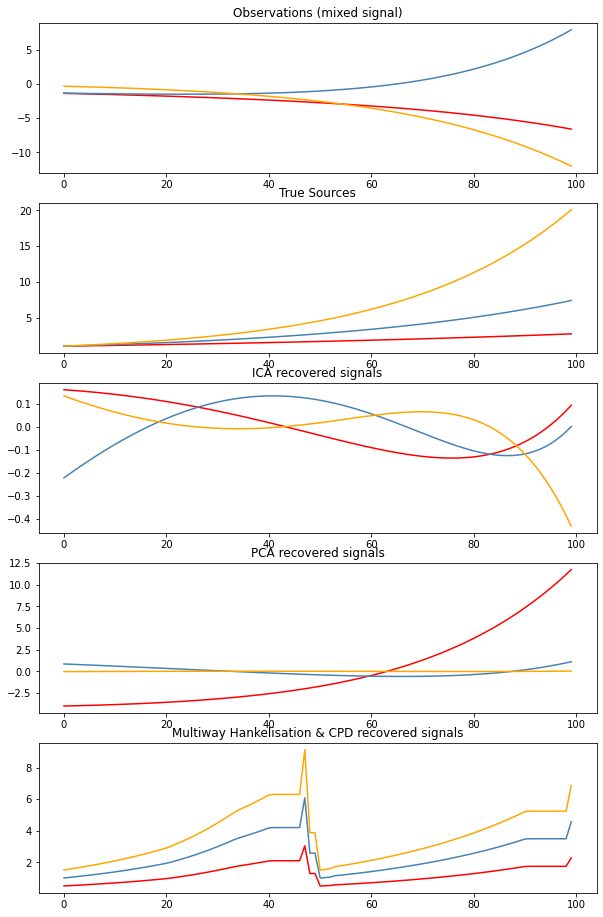

In [177]:
import matplotlib.pyplot as plt

plt.figure()

models = [X, S, S_ICA, S_PCA, S_Han]
names = [
    "Observations (mixed signal)",
    "True Sources",
    "ICA recovered signals",
    "PCA recovered signals",
    "Multiway Hankelisation & CPD recovered signals",
]
colors = ["red", "steelblue", "orange", "green"]
plt.figure(figsize=(10,16))
for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(5, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

#plt.tight_layout()
plt.show()

In [178]:
from scipy import linalg as LA

def whitenData (x):
    # Calculate the covariance matrix of the initial data.
    cov = np.cov(x)
    # Calculate eigenvalues and eigenvectors of the covariance matrix.
    d, E = LA.eigh(cov)
    # Generate a diagonal matrix with the eigenvalues as diagonal elements.
    D = np.diag(d)
    # Calculate the singular values as square root of eigenvalues
    Di = LA.sqrtm(LA.inv(D))
    # Perform whitening. xn is the whitened matrix.
    xn = np.dot(Di, np.dot(np.transpose(E), x))
    return xn

In [179]:
from scipy.io import wavfile

# Input the data from the first receiver.
samplingRate, signal1 = wavfile.read('../ch2/data/mix1.wav')
print ("Sampling rate = ", samplingRate)
print ("Data type is ", signal1.dtype)

Sampling rate =  8000
Data type is  uint8


In [180]:
# Convert the signal so that amplitude lies between 0 and 1.
signal1 = signal1 / 255.0 - 0.5  # uint8 takes values from 0 to 255

# Output information about the sound samples.
a = signal1.shape
n = a[0]
print ("Number of samples: ", n)
n = n * 1.0

Number of samples:  50000


Text(0.5, 1.0, 'Whitened data')

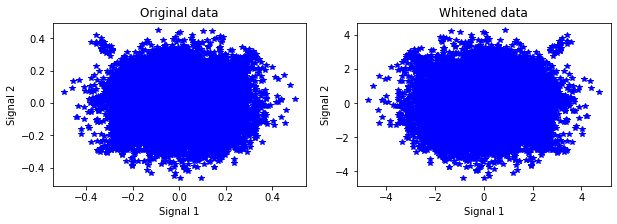

In [181]:
# Input data from the first receiver and standardise it's amplitude.
samplingRate, signal2 = wavfile.read('../ch2/data/mix2.wav')
signal2 = signal2 / 255.0 - 0.5  # uint8 takes values from 0 to 255

# x is our initial data matrix.
x = [signal1, signal2]

# Plot the signals from both sources to show correlations in the data.
fig = plt.figure( figsize=(10,3))
plt.subplot(1,2,1)
plt.title("Original data")
plt.plot(x[0], x[1], '*b')
plt.ylabel('Signal 2')
plt.xlabel('Signal 1')

X = whitenData (x)

# Plot whitened data to show new structure of the data.
plt.subplot(1,2,2)
plt.plot(X[0], X[1], '*b')
plt.ylabel('Signal 2')
plt.xlabel('Signal 1')
plt.title("Whitened data")


In [ ]:
# Separation
H = hankelize(X,Dim=1)
U = tl.tensor(H)
rank = 2
from tensorly.decomposition import constrained_parafac

_, factors = constrained_parafac(U, rank=rank, unimodality=True)
factors

In [322]:
H.shape

(1, 2, 50000)

In [ ]:
factors = np.array(factors)
factors.shape

In [ ]:
if factors[0].shape[0] < factors[1].shape[0]:
    factors[1] = np.resize(factors[1], (factors[0].shape))
else:
    factors[0] = np.resize(factors[0], (f1.shape))


In [ ]:
t1 = np.concatenate((factors[0], factors[1]))
t1.shape
#t1 = t1.reshape((len(t1[0])))

In [ ]:
Sest = dehankelize(t1) #'Dims'=[1, 1, 1])
Sest